In [2]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# Aesthetics for plotting 

In [3]:
blue_color = sns.color_palette("coolwarm")[0]   
gray_color = sns.color_palette("coolwarm")[1]  
pink_color = sns.color_palette("coolwarm")[4]
red_color = sns.color_palette("coolwarm")[5]

cmap = plt.get_cmap('coolwarm')
sample_points = np.linspace(0, 0.85, 3)
custom_palette = [cmap(p) for p in sample_points]



# Set paths for data analysis

### In this notebook I am comparing model quality metrics from two different qfit runs (with 2 different implementations). These catagories correspond to whatever catagories you specified in your run_qfit_ligand script


In [47]:
catagory_1 = '/path/to/catagory_1/data' # data should include number of output confs, RSCC, strain, EDIAm, runtime (all of which is calculated in the test_qfit_outputs script)
catagory_2 = '/path/to/catagory_2/data'

# Number of output conformers

/Users/jessicaflowers/anaconda3/envs/rdkit/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/jessicaflowers/anaconda3/envs/rdkit/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


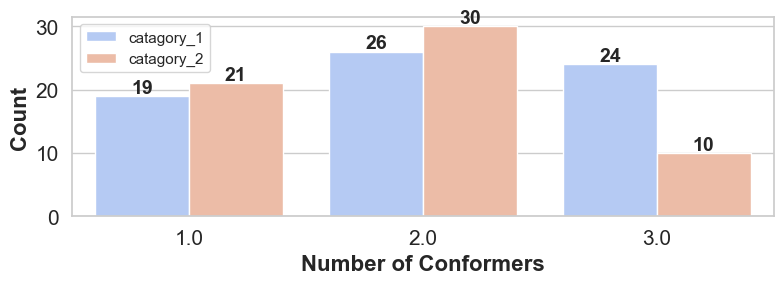

In [48]:
# Map labels to each directory
dirs = {
    'catagory_1': catagory_1,
    'catagory_2': catagory_2
}

# Dictionary to store the frequency of conformers for each directory
conformer_data = {}

# Loop over each directory and read the CSV files
for label, dir_path in dirs.items():
    csv_files = glob.glob(os.path.join(dir_path, '*_num_confs.csv'))
    conf_counts = []
    
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            conf_counts.extend(df['Number of Final Conformers'].tolist())
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")
    
    # Count the frequency of each conformer number and sort by the conformer value
    conformer_data[label] = pd.Series(conf_counts).value_counts().sort_index()

all_conformer_numbers = sorted(set().union(*(s.index for s in conformer_data.values())))

# Build a DataFrame with conformer numbers as the index and each column for a directory
plot_df = pd.DataFrame(index=all_conformer_numbers)
for label, series in conformer_data.items():
    plot_df[label] = series

# Melt the DataFrame to long format for seaborn
df_long = plot_df.reset_index().rename(columns={'index': 'Conformers'})
df_long = df_long.melt(id_vars='Conformers', var_name='Directory', value_name='Count')

# set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 3))

ax = sns.barplot(x='Conformers', y='Count', hue='Directory', data=df_long, palette="coolwarm")

# Customize labels and ticks
plt.xlabel('Number of Conformers', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add the count labels on top of the bars
for p in ax.patches:
    if p.get_x() != 0:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.5, int(height),
                ha="center", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.legend()
plt.show()


# RSCC

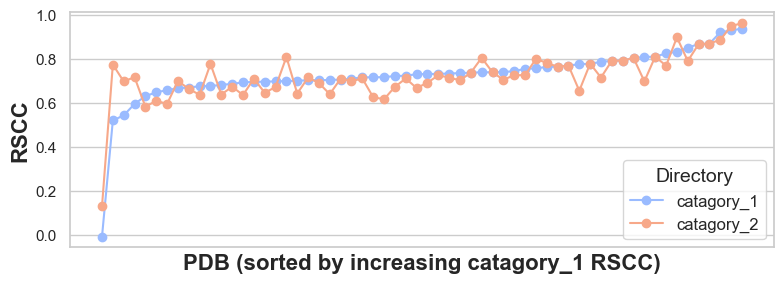

In [49]:
dirs = {
    'catagory_1': catagory_1,
    'catagory_2': catagory_2
}

# Load all RSCC values into a single DataFrame keyed by PDB
all_rscc = {}

for label, dir_path in dirs.items():
    csv_files = glob.glob(os.path.join(dir_path, '*_rscc.csv'))
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            if df.empty or 'PDB' not in df.columns:
                continue
            col_name = 'qfit_rscc' # Note!!!!! this is currently set up to compare the rscc of different qFit runs. if you want to compare qFit to deposited RSCC
            # you will have to change this col_name, i.e. something like:  
            # col_name = 'qfit_rscc' if label == 'catagory_1' else 'depo_rscc' 
            # (assuming catagory_1 is for the qfit models and catagory_2 is for the deposited models)
            for _, row in df.iterrows():
                pdb = str(row['PDB'])
                if pdb not in all_rscc:
                    all_rscc[pdb] = {}
                all_rscc[pdb][label] = row.get(col_name)
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")

# Convert dictionary to DataFrame
rscc_df = pd.DataFrame.from_dict(all_rscc, orient='index').dropna()

# Sort by PDB name 
# rscc_df = rscc_df.sort_index()
rscc_df = rscc_df.sort_values(by='catagory_1')
# Plotting
plt.figure(figsize=(8, 3))

colors = {"catagory_1": gray_color, 'catagory_2': pink_color}  

for label in dirs.keys():
    if label in rscc_df.columns:
        plt.plot(rscc_df.index, rscc_df[label], marker='o', linestyle='-', label=label, color=colors[label])


plt.xlabel("PDB (sorted by increasing catagory_1 RSCC)", fontsize=16, fontweight='bold')
plt.ylabel("RSCC", fontsize=16, fontweight='bold')
plt.xticks([])   
plt.legend(title="Directory", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


# Torsion Strain

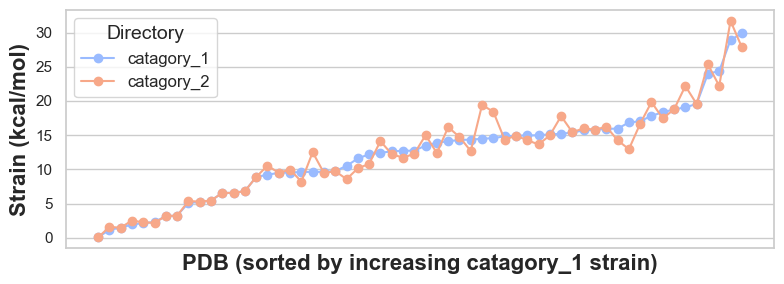

In [50]:
dirs = {
    'catagory_1': catagory_1,
    'catagory_2': catagory_2
}

# Load all strain values into a single dictionary keyed by PDB
all_strain = {}

for label, dir_path in dirs.items():
    if label == 'catagory_1':
        pattern = '*_qfit_weighted_energy.csv'
        # pattern = '*_conf_weighted_energy.csv'
    else: # i.e., if label == 'catagory_2'
        pattern = '*_qfit_weighted_energy.csv'
        # pattern = '*_conf_weighted_energy.csv' 
        # pattern = '*_depo_weighted_energy.csv'

        # same as with the rscc plot, you might have to change the pattern naming convention (1 example shown for how to do this) based on how you labeled the output files when you ran the torsion strain calc script

    csv_files = glob.glob(os.path.join(dir_path, pattern))
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            if df.empty or 'Weighted_Average_Energy' not in df.columns:
                continue
            pdb = os.path.basename(csv_file).split('_')[0]
            if pdb not in all_strain:
                all_strain[pdb] = {}
            all_strain[pdb][label] = df['Weighted_Average_Energy'].iloc[0]
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")

# Convert to DataFrame and drop any missing values
strain_df = pd.DataFrame.from_dict(all_strain, orient='index').dropna()

# Sort by increasing catagory_1 strain
strain_df = strain_df.sort_values(by='catagory_1') # can comment this out if you dont want to sort it like this

# Plot 
plt.figure(figsize=(8, 3))

colors = {"catagory_1": gray_color, 'catagory_2': pink_color}

for label in dirs.keys():
    if label in strain_df.columns:
        plt.plot(strain_df.index, strain_df[label], marker='o', linestyle='-', label=label, color=colors[label])

plt.xlabel("PDB (sorted by increasing catagory_1 strain)", fontsize=16, fontweight='bold')
plt.ylabel("Strain (kcal/mol)", fontsize=16, fontweight='bold')
plt.xticks([])  # No PDB labels since they are long, can comment this out for a smaller dataset (i.e., if you DO want to show PDBs on x-axis)
plt.legend(title="Directory", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


# Runtime

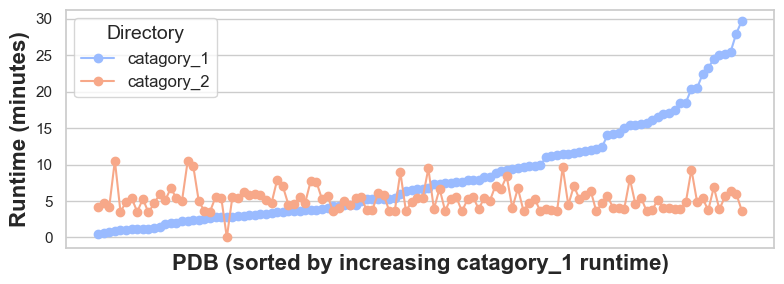

In [42]:
dirs = {
    'catagory_1': catagory_1,
    'catagory_2': catagory_2
}

all_runtimes = {}

for label, dir_path in dirs.items():
    csv_files = glob.glob(os.path.join(dir_path, '*_qfit_runtime.csv'))
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            if df.empty or 'PDBID' not in df.columns:
                continue
            # Clean 'Time' column (strip 's' and convert from seconds to minutes)
            df['Time'] = df['Time'].str.rstrip('s').astype(float) / 60
            for _, row in df.iterrows():
                pdb = row['PDBID']
                if pdb not in all_runtimes:
                    all_runtimes[pdb] = {}
                all_runtimes[pdb][label] = row['Time']
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")

runtime_df = pd.DataFrame.from_dict(all_runtimes, orient='index').dropna()

# Sort by increasing catagory_1 runtime
runtime_df = runtime_df.sort_values(by='catagory_1')  # can comment this out if you dont want to sort in this way

# Plot 
plt.figure(figsize=(8, 3))

colors = {"catagory_1": gray_color, 'catagory_2': pink_color}

for label in dirs.keys():
    if label in runtime_df.columns:
        plt.plot(runtime_df.index, runtime_df[label], marker='o', linestyle='-', label=label, color=colors[label])

plt.xlabel("PDB (sorted by increasing catagory_1 runtime)", fontsize=16, fontweight='bold')
plt.ylabel("Runtime (minutes)", fontsize=16, fontweight='bold')
plt.xticks([])  # Hide PDB labels if too many
plt.legend(title="Directory", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


# EDIAm

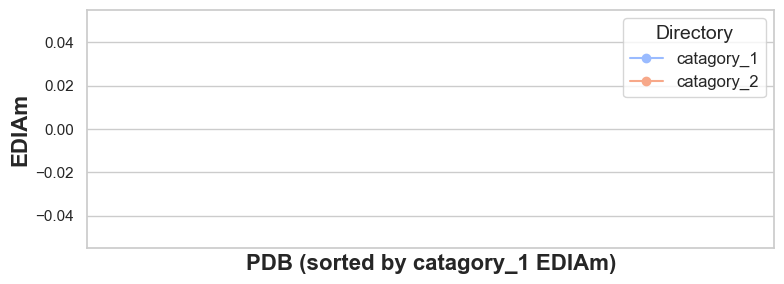

In [40]:
# Map labels to each directory
dirs = {
    'catagory_1': catagory_1,
    'catagory_2': catagory_2
}

# Load all EDIAm values into a unified dict keyed by PDB
all_edia = {}
for label, dir_path in dirs.items():
    csv_files = glob.glob(os.path.join(dir_path, '*_edia_opia.csv'))
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            if df.empty or 'PDBID' not in df.columns:
                continue
            for _, row in df.iterrows():
                # Strip _catagory suffix
                pdb = row['PDBID'].replace("_catagory_1", "").replace("_catagory_2", "") # note that you WILL have to edit _catagory_1 and _catagory_2 here to match whatever catagories you used in your run_qfit_ligand script
                if pdb not in all_edia:
                    all_edia[pdb] = {}
                all_edia[pdb][label] = row.get('EDIAm')
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")

# Convert to DataFrame and drop rows missing any EDIAm value
edia_df = pd.DataFrame.from_dict(all_edia, orient='index').dropna()

# Sort by increasing catagory_1 EDIAm
edia_df = edia_df.sort_values(by='catagory_1') # can comment out 

# Plot
plt.figure(figsize=(8, 3))
colors = {"catagory_1": gray_color, "catagory_2": pink_color}

for label in dirs.keys():
    if label in edia_df.columns:
        plt.plot(edia_df.index, edia_df[label], marker='o', linestyle='-', label=label, color=colors[label])

plt.xlabel("PDB (sorted by catagory_1 EDIAm)", fontsize=16, fontweight='bold')
plt.ylabel("EDIAm", fontsize=16, fontweight='bold')
plt.xticks([])  # hide PDBs if too long
plt.legend(title="Directory", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

# RSCC vs Strain

Number of PDBs = 58


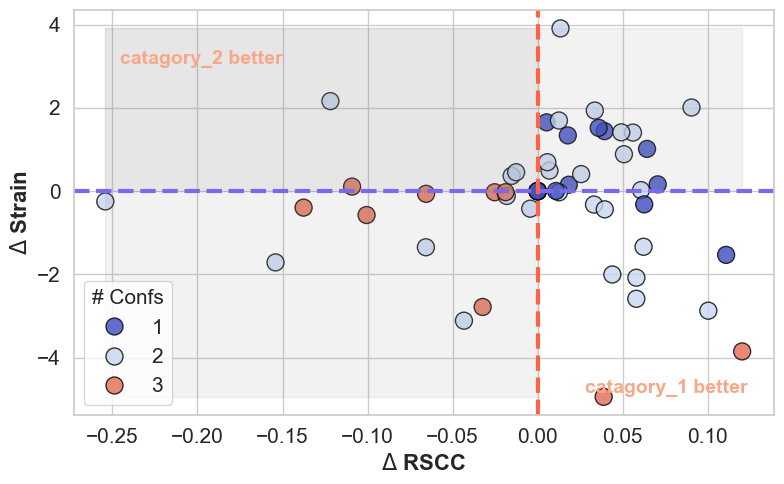

In [65]:
# this plot is going to be colored by the number of output conformers from the 'catagory_2' catagory. you can change this to whichever catagory you want
csv_files = glob.glob(os.path.join(catagory_2, '*_num_confs.csv'))

catagory_2_confs = {}

for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        if df.empty or 'PDBID' not in df.columns or 'Number of Final Conformers' not in df.columns:
            continue
        for _, row in df.iterrows():
            pdb = row['PDBID']
            catagory_2_confs[pdb] = row['Number of Final Conformers']
    except Exception as e:
        print(f"Error reading {csv_file}: {e}")

catagory_2_confs_df = pd.DataFrame.from_dict(catagory_2_confs, orient='index', columns=['catagory_2_num_confs'])

# Prepare merged dataset 

# delta rscc = catagory_1 - catagory_2 --> positive values means catagory_1 model is better (has a higher rscc)
rscc_df['Delta_RSCC'] = rscc_df['catagory_1'] - rscc_df['catagory_2']

# delta strain = catagory_1 - catagory_2 --> positive values means catagory_1 model is worse (has a higher torsion strain)
strain_df['Delta_Strain'] = strain_df['catagory_1'] - strain_df['catagory_2']

# Merge the two delta values into a single DataFrame
merged_deltas = pd.DataFrame({
    'Delta_RSCC': rscc_df['Delta_RSCC'],
    'Delta_Strain': strain_df['Delta_Strain']
})

plot_data = merged_deltas.merge(catagory_2_confs_df, left_index=True, right_index=True)
# Drop any rows without data  
plot_data = plot_data.dropna()
# make sure 'Number of Conformers' is integer
plot_data['catagory_2_num_confs'] = plot_data['catagory_2_num_confs'].astype(int)

print(f'Number of PDBs = {len(plot_data)}')

# Plotting 
plt.figure(figsize=(8, 5))

scatter = sns.scatterplot(
    x='Delta_RSCC', 
    y='Delta_Strain', 
    hue='catagory_2_num_confs',
    data=plot_data,
    edgecolor="black",
    alpha=0.8,
    s=150,
    palette=custom_palette
)

# Shading quadrants
plt.fill_betweenx(
    y=[plot_data['Delta_Strain'].min(), plot_data['Delta_Strain'].max()],
    x1=plot_data['Delta_RSCC'].min(), x2=0,
    color='gray', alpha=0.1
)

plt.fill_between(
    x=[plot_data['Delta_RSCC'].min(), plot_data['Delta_RSCC'].max()],
    y1=0, y2=plot_data['Delta_Strain'].max(),
    color='gray', alpha=0.1
)


# add text 'catagory_1 better' in lower right quadrant and 'catagory_2 better' in upper left quadrant 
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

# Add quadrant labels
plt.text(
    x=0.2 * x_max, y=0.9 * y_min,
    s='catagory_1 better',
    fontsize=14, fontweight='bold', color=pink_color
) # it is probably a good idea to comment these out and just add text to the plot yourself in some editing software, but this should at least be useful here to clarify how to interpret the results 


plt.text(
    x=0.9 * x_min, y=0.7 * y_max,
    s='catagory_2 better',
    fontsize=14, fontweight='bold', color=pink_color
) # it is probably a good idea to comment these out and just add text to the plot yourself in some editing software, but this should at least be useful here to clarify how to interpret the results 



# Axis labels
plt.xlabel('$\Delta$ RSCC', fontsize=16, fontweight='bold')
plt.ylabel('$\Delta$ Strain', fontsize=16, fontweight='bold')
plt.axhline(y=0, color='mediumslateblue', linestyle='--', linewidth=3)
plt.axvline(x=0, color='tomato', linestyle='--', linewidth=3)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(title='# Confs', title_fontsize=15, fontsize=15, loc='lower left')
plt.tight_layout()
plt.show()




# Analysis 

In [54]:
bold = "\033[1m"
endbold = "\033[0m"

# do whatever analysis you want, but here are just a few basic ideas that you should probably care about

####################################
# RSCC Analysis 
print(f"{bold}RSCC ANALYSIS{endbold}")
# 1. Number of PDBs where catagory_1 RSCC > catagory_2 RSCC
num_catagory_1_better = (rscc_df['catagory_1'] > rscc_df['catagory_2']).sum()

# 2. Percentage of total
percentage_catagory_1_better = (num_catagory_1_better / len(rscc_df)) * 100

# 3. Average delta (catagory_1 RSCC - catagory_2 RSCC)
delta = rscc_df['catagory_1'] - rscc_df['catagory_2']
average_delta = delta.mean()

# Print results 
print(f"Total PDBs: {len(rscc_df)}")
print(f"Number of PDBs where catagory_1 RSCC > catagory_2: {num_catagory_1_better}")
print(f"Percentage of PDBs where catagory_1 RSCC > catagory_2: {percentage_catagory_1_better:.2f}%")
print(f"Average delta (catagory_1 RSCC - catagory_2 RSCC): {average_delta:.4f}")
print('\n')

####################################
# Strain Analysis 
print(f"{bold}STRAIN ANALYSIS{endbold}")

# 1. Number of PDBs where catagory_1 strain < catagory_2 strain
num_catagory_1_lower_strain = (strain_df['catagory_1'] < strain_df['catagory_2']).sum()

# 2. Percentage of total
percentage_catagory_1_lower_strain = (num_catagory_1_lower_strain / len(strain_df)) * 100

# 3. Average delta (catagory_1 strain - catagory_2 strain)
delta_strain = strain_df['catagory_1'] - strain_df['catagory_2']
average_delta_strain = delta_strain.mean()

#  Print results 
print(f"Total PDBs: {len(strain_df)}")
print(f"Number of PDBs where catagory_1 strain < catagory_2: {num_catagory_1_lower_strain}")
print(f"Percentage of PDBs where catagory_1 strain < catagory_2: {percentage_catagory_1_lower_strain:.2f}%")
print(f"Average delta (catagory_1 strain - catagory_2 strain): {average_delta_strain:.4f}")


####################################
# runtimes 
print('\n')
print(f"{bold}RUNTIME ANALYSIS{endbold}")
# 1. Number of PDBs where catagory_1 strain < catagory_2 strain
num_catagory_1_lower_runtime = (runtime_df['catagory_1'] < runtime_df['catagory_2']).sum()

# 2. Percentage of total
percentage_catagory_1_lower_runtime = (num_catagory_1_lower_runtime / len(runtime_df)) * 100

# 3. Average delta (catagory_1 strain - catagory_2 strain)
delta_runtime = runtime_df['catagory_1'] - runtime_df['catagory_2']
average_delta_runtime = delta_runtime.mean()

# Print results
print(f"Total PDBs: {len(strain_df)}")
print(f"Number of PDBs where catagory_1 runtime < catagory_2: {num_catagory_1_lower_runtime}")
print(f"Percentage of PDBs where catagory_1 runtime < catagory_2: {percentage_catagory_1_lower_runtime:.2f}%")
print(f"Average delta (catagory_1 runtime - catagory_2 runtime): {average_delta_runtime:.4f}")


RSCC ANALYSIS
Total PDBs: 60
Number of PDBs where catagory_1 RSCC > catagory_2: 36
Percentage of PDBs where catagory_1 RSCC > catagory_2: 60.00%
Average delta (catagory_1 RSCC - catagory_2 RSCC): 0.0051


STRAIN ANALYSIS
Total PDBs: 58
Number of PDBs where catagory_1 strain < catagory_2: 25
Percentage of PDBs where catagory_1 strain < catagory_2: 43.10%
Average delta (catagory_1 strain - catagory_2 strain): -0.1361


RUNTIME ANALYSIS
Total PDBs: 58
Number of PDBs where catagory_1 runtime < catagory_2: 48
Percentage of PDBs where catagory_1 runtime < catagory_2: 41.38%
Average delta (catagory_1 runtime - catagory_2 runtime): 3.2089
